# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 32
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

In [8]:
element_gameweek_df['clean_sheets_no_time'] =\
element_gameweek_df['goals_conceded'].apply(lambda x: 1 if x == 0 else 0)

# Models

## Simple Binomial model

### Preparing data

In [9]:
spm_df = element_gameweek_df.copy()

In [10]:
spm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [11]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [12]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'clean_sheets_no_time')

In [13]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [14]:
spm_response_df.head()

78    0
80    0
81    0
82    0
83    0
Name: clean_sheets_no_time, dtype: int64

### Fitting model

In [15]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [16]:
print(spm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8161
Model:                              GLM   Df Residuals:                     8160
Model Family:                  Binomial   Df Model:                            0
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -5426.6
Date:                  Thu, 04 Apr 2019   Deviance:                       10853.
Time:                          18:48:17   Pearson chi2:                 8.16e+03
No. Iterations:                       4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4818      0.023    -21.148      0.000      -0.527      -0.437


### Model fit

In [17]:
spm_results.aic

10855.250723923336

In [18]:
spm_results.bic

-62644.86471014567

In [19]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(False, 0.49479554777644674)

In [20]:
spm_results.resid_deviance.describe()

count    8161.000000
mean       -0.076470
std         1.150742
min        -0.980784
25%        -0.980784
50%        -0.980784
75%         1.387672
max         1.387672
dtype: float64

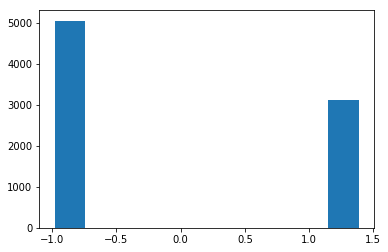

In [21]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Binomial minutes model

### Preparing data

In [22]:
spmm_df = element_gameweek_df.copy()

In [23]:
spmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [24]:
spmm_df['log_minutes'] = np.log(spmm_df['minutes'])

In [25]:
spmm_df = player.remove_redundant_columns(spmm_df, spmm_redundant_columns)

In [26]:
spmm_response_df, spmm_explanatory_df = player.get_response_explanatory_dfs(spmm_df, 'clean_sheets_no_time')

In [27]:
spmm_explanatory_df.columns

Index(['const', 'log_minutes'], dtype='object')

### Fitting model

In [28]:
spmm_results = sm.GLM(
    spmm_response_df,
    spmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [29]:
print(spmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8161
Model:                              GLM   Df Residuals:                     8159
Model Family:                  Binomial   Df Model:                            1
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4881.5
Date:                  Thu, 04 Apr 2019   Deviance:                       9763.0
Time:                          18:48:17   Pearson chi2:                 8.35e+03
No. Iterations:                       5                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.3317      0.142     23.417      0.000       3.053       3.611
log_minutes    -0.9467      0.0

### Model fit

In [30]:
spmm_results.aic

9767.017587567554

In [31]:
spmm_results.bic

-63726.090724511996

In [32]:
spmm_pearson_results = goodness_fit.pearson_chi_squared_test(spmm_results)
spmm_pearson_results

(False, 0.06457867188601518)

In [33]:
spmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.078081
std         1.091032
min        -2.594905
25%        -0.816116
50%        -0.816116
75%         1.117004
max         1.588358
dtype: float64

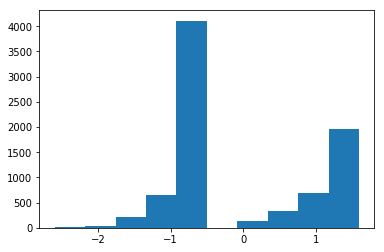

In [34]:
plt.figure()
plt.hist(spmm_results.resid_deviance)
plt.show()

## Simple Binomial teams model

### Preparing data

In [35]:
sptm_df = element_gameweek_df.copy()

In [36]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [37]:
sptm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [38]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [39]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'clean_sheets_no_time')

In [40]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [41]:
sptm_response_df.head()

78    0
80    0
81    0
82    0
83    0
Name: clean_sheets_no_time, dtype: int64

### Fitting model

In [42]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [43]:
print(sptm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8161
Model:                              GLM   Df Residuals:                     8119
Model Family:                  Binomial   Df Model:                           41
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4901.5
Date:                  Thu, 04 Apr 2019   Deviance:                       9802.9
Time:                          18:48:19   Pearson chi2:                 8.13e+03
No. Iterations:                       4                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.1121      0.176    -11.982      0.000      -2.458      -1.767
was_home  

### Model fit

In [44]:
sptm_results.aic

9886.923918834633

In [45]:
sptm_results.bic

-63325.89951366615

In [46]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(False, 0.47443236683393963)

In [47]:
sptm_results.resid_deviance.describe()

count    8161.000000
mean       -0.069287
std         1.093864
min        -2.092273
25%        -0.946923
50%        -0.646931
75%         1.127643
max         2.342404
dtype: float64

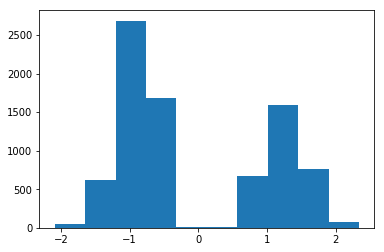

In [48]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Binomial teams minutes model

### Preparing data

In [49]:
sptmm_df = element_gameweek_df.copy()

In [50]:
sptmm_df = player.add_categorical_variables(sptmm_df, 'element_type')
sptmm_df = player.add_categorical_variables(sptmm_df, 'opposition_team')
sptmm_df = player.add_categorical_variables(sptmm_df, 'own_team')

In [51]:
sptmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes'
]

In [52]:
sptmm_df['log_minutes'] = np.log(sptmm_df['minutes'])

In [53]:
sptmm_df = player.remove_redundant_columns(sptmm_df, sptmm_redundant_columns)

In [54]:
sptmm_response_df, sptmm_explanatory_df = player.get_response_explanatory_dfs(sptmm_df, 'clean_sheets_no_time')

In [55]:
sptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [56]:
sptmm_results = sm.GLM(
    sptmm_response_df,
    sptmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [57]:
print(sptmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8161
Model:                              GLM   Df Residuals:                     8118
Model Family:                  Binomial   Df Model:                           42
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4359.3
Date:                  Thu, 04 Apr 2019   Deviance:                       8718.7
Time:                          18:48:20   Pearson chi2:                 8.53e+03
No. Iterations:                       5                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3167      0.246      9.403      0.000       1.834       2.800
was_home  

### Model fit

In [58]:
sptmm_results.aic

8804.653348650158

In [59]:
sptmm_results.bic

-64401.16296186115

In [60]:
sptmm_pearson_results = goodness_fit.pearson_chi_squared_test(sptmm_results)
sptmm_pearson_results

(True, 0.0007381941636859235)

In [61]:
sptmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.071571
std         1.031184
min        -3.289014
25%        -0.837748
50%        -0.518673
75%         0.962071
max         2.288924
dtype: float64

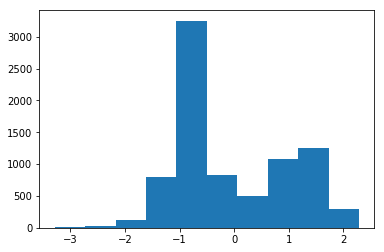

In [62]:
plt.figure()
plt.hist(sptmm_results.resid_deviance)
plt.show()

## Simple Binomial player model

### Preparing data

In [63]:
sppm_df = element_gameweek_df.copy()

In [64]:
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [65]:
sppm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [66]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [67]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'clean_sheets_no_time')

In [68]:
sppm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_592', 'element_593', 'element_594', 'element_599',
       'element_601', 'element_602', 'element_603', 'element_605',
       'element_607', 'element_608'],
      dtype='object', length=479)

### Fitting model

In [69]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [70]:
print(sppm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8161
Model:                              GLM   Df Residuals:                     7682
Model Family:                  Binomial   Df Model:                          478
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4625.8
Date:                  Thu, 04 Apr 2019   Deviance:                       9251.5
Time:                          18:48:45   Pearson chi2:                 7.98e+03
No. Iterations:                      23                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3532      0.706     -3.331      0.001      -3.738      -0.969
was_home  

### Model fit

In [71]:
sppm_results.aic

10209.539448857726

In [72]:
sppm_results.bic

-59941.17167424499

In [73]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(True, 0.008945553700192899)

In [74]:
sppm_results.resid_deviance.describe()

count    8161.000000
mean       -0.067070
std         1.062670
min        -2.298247
25%        -0.898995
50%        -0.564375
75%         1.045702
max         2.449135
dtype: float64

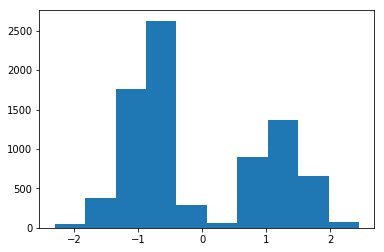

In [75]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Binomial player minutes model

### Preparing data

In [76]:
sppmm_df = element_gameweek_df.copy()

In [77]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [78]:
sppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'goals_scored',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes'
]

In [79]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [80]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [81]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'clean_sheets_no_time')

In [82]:
sppmm_explanatory_df.columns

Index(['const', 'was_home', 'opposition_team_2', 'opposition_team_3',
       'opposition_team_4', 'opposition_team_5', 'opposition_team_6',
       'opposition_team_7', 'opposition_team_8', 'opposition_team_9',
       ...
       'element_593', 'element_594', 'element_599', 'element_601',
       'element_602', 'element_603', 'element_605', 'element_607',
       'element_608', 'log_minutes'],
      dtype='object', length=480)

### Fitting model

In [83]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [84]:
print(sppmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 8161
Model:                              GLM   Df Residuals:                     7681
Model Family:                  Binomial   Df Model:                          479
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4218.7
Date:                  Thu, 04 Apr 2019   Deviance:                       8437.5
Time:                          18:49:01   Pearson chi2:                 8.28e+03
No. Iterations:                      23                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3844      0.746      3.196      0.001       0.922       3.847
was_home  

### Model fit

In [85]:
sppmm_results.aic

9397.492246035312

In [86]:
sppmm_results.bic

-60746.21175507794

In [87]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(True, 1.1195786013828979e-06)

In [88]:
sppmm_results.resid_deviance.describe()

count    8161.000000
mean       -0.069114
std         1.014509
min        -2.988723
25%        -0.819186
50%        -0.485085
75%         0.917354
max         2.628326
dtype: float64

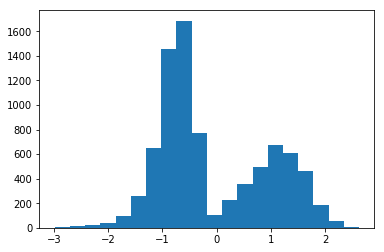

In [89]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.show()

# Model comparison

In [90]:
aic = {
    'Simple Binomial': spm_results.aic,
    'Binomial teams': sptm_results.aic,
    'Binomial players': sppm_results.aic,
    
    'Simple Binomial minutes': spmm_results.aic,
    'Binomial teams minutes': sptmm_results.aic,
    'Binomial players minutes': sppmm_results.aic,
    }
aic

{'Simple Binomial': 10855.250723923336,
 'Binomial teams': 9886.923918834633,
 'Binomial players': 10209.539448857726,
 'Simple Binomial minutes': 9767.017587567554,
 'Binomial teams minutes': 8804.653348650158,
 'Binomial players minutes': 9397.492246035312}

In [91]:
bic = {
    'Simple Binomial': spm_results.bic,
    'Binomial teams': sptm_results.bic,
    'Binomial players': sppm_results.bic,
    
    'Simple Binomial minutes': spmm_results.bic,
    'Binomial teams minutes': sptmm_results.bic,
    'Binomial players minutes': sppmm_results.bic,
    }
bic

{'Simple Binomial': -62644.86471014567,
 'Binomial teams': -63325.89951366615,
 'Binomial players': -59941.17167424499,
 'Simple Binomial minutes': -63726.090724511996,
 'Binomial teams minutes': -64401.16296186115,
 'Binomial players minutes': -60746.21175507794}

In [93]:
comp_df = pd.DataFrame([
    aic,
    bic
]).T
comp_df.columns = [
    'AIC',
    'BIC'
]
comp_df.astype('int64')

,AIC,BIC
Binomial players,10209,-59941
Binomial players minutes,9397,-60746
Binomial teams,9886,-63325
Binomial teams minutes,8804,-64401
Simple Binomial,10855,-62644
Simple Binomial minutes,9767,-63726
